# Activities Classification with Explainable AI (XAI)

<!-- ![title](Figure_2.png) -->

In [1]:
from shapash import SmartExplainer
import numpy as np
import xgboost as xgb
import lightgbm as ltb
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import random

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


## Opening the files
Load the training/testing dataset from csv files
first column: ID
last column: the expected output, for example: 1, 2, 3, corresponds to one of 3 activities
+ 1: web browsing/file downloading
+ 2: online communication, like video call
+ 3: online video watching

In [2]:
# Load the training/testing dataset from csv files
training_dataset = pd.read_csv("../../output_train.csv", header=0, usecols=[*range(1,23)], sep=";")
testing_dataset = pd.read_csv("../../output_test.csv", header=0, usecols=[*range(1,23)], sep=";")

poison_dataset = pd.read_csv("../../poison/generated-5000.csv")

# Remove missing values
training_dataset.dropna(axis = 0, inplace = True)
testing_dataset.dropna(axis = 0, inplace = True)
poison_dataset.dropna(axis = 0, inplace=True)

print("The shape of the training dataset: " + str(training_dataset.shape))
print("The shape of the testing dataset: " + str(testing_dataset.shape))
print("The shape of the testing dataset: " + str(poison_dataset.shape))

training_dataset.head()

The shape of the training dataset: (279, 22)
The shape of the testing dataset: (103, 22)
The shape of the testing dataset: (5000, 22)


,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s,output
0,4.999674,100.000000,0.000000,99090,54,54,54.000000,0.000000,1.652834,5896066,...,1564.358185,313.304936,98.347166,1835,3769,32.744468,67.255532,1199.109362,1120.873063,1
1,0.892125,100.000000,0.000000,32184,54,54,54.000000,0.000000,1.673617,1890837,...,1594.297639,601.903863,98.326383,596,1186,33.445567,66.554433,2155.550758,1997.477642,1
2,3.412767,99.857265,0.142735,77133,471,54,55.213314,18.696881,2.276791,3310662,...,1571.268154,562.653689,97.723209,1397,2107,39.868721,60.131279,992.682790,1026.732873,1
3,4.999285,99.888471,0.111529,142985,471,54,54.699694,14.495354,1.925924,7281243,...,1597.114060,649.341567,98.074076,2614,4559,36.442214,63.557786,1485.057968,1434.805182,1
4,1.682172,100.000000,0.000000,60534,54,54,54.000000,0.000000,1.571208,3792170,...,1645.907118,1250.277675,98.428792,1121,2304,32.729927,67.270073,2290.315058,2036.058071,1


In [3]:
# Set of features in the dataset
features = list(testing_dataset.columns)
print(features[:-1])

['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [4]:
# Convert the expected output into arrays, e.g., 1 -> [1, 0, 0]
output_training = []
for i, val in enumerate(training_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_training.append(temp)

output_testing = []
for i, val in enumerate(testing_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_testing.append(temp)

output_poisoning = []
for i, val in enumerate(poison_dataset.iloc[:,-1]):
    temp = [0, 0, 0]
    temp[int(val) - 1] = 1
    output_poisoning.append(temp)

# Remove the expected output column from the datasets
prep_training_dataset = training_dataset.drop(columns=['output'])
prep_testing_dataset = testing_dataset.drop(columns=['output'])

prep_poison_dataset = poison_dataset.drop(poison_dataset.columns[-1],axis=1)

# Preprocessing the data
scaler = StandardScaler()
scaler.fit(prep_training_dataset)
# scaler.fit(prep_poison_dataset)

# Apply transform to both the training/testing dataset.
X_train = scaler.transform(prep_training_dataset)
Y_train = np.array(output_training)

X_test = scaler.transform(prep_testing_dataset)
Y_test = np.array(output_testing)

X_poison = scaler.transform(prep_poison_dataset)
Y_poison = np.array(output_poisoning)

print("Preprocessed inputs of the training dataset: " + str(X_train))
print("Preprocessed outputs of the training dataset: " + str(Y_train))
# print("Preprocessed outputs of the poisoning dataset: " + str(Y_train))

Preprocessed inputs of the training dataset: [[ 1.24949172  0.59231316 -0.58844871 ...  0.54501086  0.2208743
   0.62843195]
 [-0.8505485   0.59231316 -0.58844871 ...  0.4955518   0.97523057
   1.92817113]
 [ 0.43816388  0.5886868  -0.58480418 ...  0.04242978  0.0580633
   0.48885055]
 ...
 [-1.2056687   0.34743347 -0.34234218 ... -0.71477922 -0.56070378
  -0.41047599]
 [-0.89460259  0.58409106 -0.58018542 ...  0.10394211  0.44768975
   1.24034932]
 [-0.98176026  0.59231316 -0.58844871 ... -0.62260254  0.43111073
  -0.53651579]]
Preprocessed outputs of the training dataset: [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0

In [5]:
'''
This function creates the poisoning values based on poison type
type:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''
def get_poison_set(X_train, Y_train, X_poison=None, Y_poison=None, poison_type='new_example', percentage=0, target_bias_class=None):
    X_train_ = X_train.copy().tolist()
    Y_train_ = Y_train.copy().tolist()
    poison_count = -1
    original_count = -1
    if poison_type=='new_example':
        required_samples = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train)
        poison_count = required_samples
        # if len(X_poison)>=required_samples:
        to_copy_idx =[i for i in range(len(X_poison))]
        random.shuffle(to_copy_idx)
        for i in range(required_samples):
            X_train_.append(X_poison[to_copy_idx[i]])
            Y_train_.append(Y_poison[to_copy_idx[i]])
        
    elif poison_type=='random_swapping':
        flip_amount = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train) - flip_amount
        poison_count = flip_amount

        print(len(X_train_)>=flip_amount)
        if len(X_train_)>=flip_amount:
            for i in range(flip_amount):
                flip_idx_1 = random.randint(0,len(Y_train_)-1)
                flip_idx_2 = random.randint(0,len(Y_train_)-1)
                Y_train_[flip_idx_1], Y_train_[flip_idx_2] = Y_train_[flip_idx_2], Y_train_[flip_idx_1]

    elif poison_type=='targeted_flipping':
        flip_amount = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train) - flip_amount
        poison_count = flip_amount
        flip_amount = int(len(X_train_)*percentage*0.01)
        if len(X_train_)>=flip_amount:
            for i in range(flip_amount):
                flip_idx_1 = random.randint(0,len(Y_train_)-1)
                Y_train_[flip_idx_1] = target_bias_class
        
        else:
            raise Exception('Poison percentage should not exceed 100 percent')
    else: 
        raise Exception('Cannot recognize poison_type. It should be in one of the followings: new_example, random_swapping, and targeted_flipping')
            
    return np.asarray(X_train_), np.asarray(Y_train_), poison_count, original_count

In [6]:
def impact_metric_spatial(FP, F, is_F1=False):
    if is_F1:
        FP = 1-FP
        F = 1-F
        
    return (FP-F)/F

In [7]:
def complexity_spatial(DP, D):
    return DP/(D + DP)

In [8]:
def evaluate_spatial_metrics_poison_impact(X_test, Y_test, ct_poison, ct_original, model, model_poison, model_type='lightgbm'):  
    
    if(model_type=='NN'):
        # evaluating without poisoning 
        _, accuracy_original = model.evaluate(X_test, Y_test)
        # Evaluate the Keras model
        _, accuracy_poisoned = model_poison.evaluate(X_test, Y_test)
        
        # Make class predictions with the models
        predictions_original = (model.predict(X_test) > 0.5).astype(int)
        predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        f1_original = f1_score(Y_test, predictions_original, average="macro")
        f1_poisoned = f1_score(Y_test, predictions_poisoned, average="macro")

    elif(model_type=='xgboost'):
        pred_ori = model.predict(X_test)
        pred_poi = model_poison.predict(X_test)
        
        accuracy_original = accuracy_score(np.argmax(Y_test,axis=1),np.argmax(pred_ori,axis=1))
        accuracy_poisoned = accuracy_score(np.argmax(Y_test,axis=1),np.argmax(pred_poi,axis=1))
        
        # Make class predictions with the models
        predictions_original = (model.predict(X_test) > 0.5).astype(int)
        predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        f1_original = f1_score(Y_test, predictions_original, average="macro")
        f1_poisoned = f1_score(Y_test, predictions_poisoned, average="macro")
    
    elif(model_type=='lightgbm'):
        pred_ori = model.predict(X_test)
        pred_poi = model_poison.predict(X_test)
        
        accuracy_original = accuracy_score(np.argmax(Y_test,axis=1),pred_ori)
        accuracy_poisoned = accuracy_score(np.argmax(Y_test,axis=1),pred_poi)
        
        # Make class predictions with the models
        predictions_original = (model.predict(X_test) > 0.5).astype(int)
        predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        f1_original = f1_score(np.argmax(Y_test,axis=1), predictions_original, average="macro")
        f1_poisoned = f1_score(np.argmax(Y_test,axis=1), predictions_poisoned, average="macro")
    
    elif(model_type=='random_forest'):
        pred_ori = model.predict(X_test)
        pred_poi = model_poison.predict(X_test)
        
        accuracy_original = accuracy_score(np.argmax(Y_test,axis=1),pred_ori)
        accuracy_poisoned = accuracy_score(np.argmax(Y_test,axis=1),pred_poi)
        
        # Make class predictions with the models
        predictions_original = (model.predict(X_test) > 0.5).astype(int)
        predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        f1_original = f1_score(np.argmax(Y_test,axis=1), predictions_original, average="macro")
        f1_poisoned = f1_score(np.argmax(Y_test,axis=1), predictions_poisoned, average="macro")
    
    # impact metric
    print('accuracy original: %.2f'% (accuracy_original))
    print('accuracy poisoned: %.2f'% (accuracy_poisoned))
    print('f1 original: %.2f'% (f1_original))
    print('f1 poisoned: %.2f'% (f1_poisoned))

    impact = impact_metric_spatial(f1_poisoned, f1_original, is_F1=True)
    complexity = complexity_spatial(ct_poison,ct_original)
    
    return impact, complexity, accuracy_original, accuracy_poisoned, f1_original, f1_poisoned

In [9]:
def get_models_for_attack(epochs=150, verbose=0, model_type='lightgbm'):
    if(model_type=='NN'):
        model = Sequential()
        model.add(Dense(12, input_shape=(21,), activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(3, activation='sigmoid'))

        # Compile the Keras model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        model_cp = clone_model(model)
        model_cp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, Y_train, epochs=epochs, batch_size=10, verbose=verbose)
        return model, model_cp
    
    elif(model_type=='xgboost'):
        xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
        
        model_cp = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
        xg_reg.fit(X_train,Y_train)
        return xg_reg, model_cp
    
    elif(model_type=='lightgbm'):
        model = ltb.LGBMClassifier()
        model_cp = ltb.LGBMClassifier()
        model.fit(X_train,np.argmax(Y_train,axis=1))
        return model, model_cp
    
    elif(model_type=='random_forest'):
        model = RandomForestClassifier(min_samples_leaf=2, random_state=0)
        model.fit(X_train, np.argmax(Y_train,axis=1))
        model_cp = RandomForestClassifier(min_samples_leaf=2, random_state=0)
        
        return model, model_cp

In [10]:
# model, model_cp = get_models_for_attack()
# X_test, Y_test, ct_poison, ct_original, model, model_poison
# impact,complexity,_,_,_,_ = evaluate_spatial_metrics_poison_impact(
#     X_test=X_test, Y_test=Y_test,
#     poison_percentage=10, poison_type='new_example', model=model, model_poison=model_cp, train_epochs=150, batch_size=10, 
#     is_trained_model_available = True, verbose=0)
# print(impact)
# print(complexity)

In [11]:
'''types:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''
def get_impact_over_range_of_poisoning(poison_range, num_exp, poison_type='new_example', epochs=100, batch_size=10, verbose=0, target_bias_class=None, model_type='lightgbm'):
    impact_vals = []
    accuracy_vals = []
    complexity_vals = []
    for i in range(num_exp):
        print('running experiment: %d'%(i))
        per_exp_round = []
        complexity_round = []
        for poison_percent in poison_range:
            print('poisoning percentage: %d'%(poison_percent))
            # poisoning a model
            model, model_cp = get_models_for_attack(epochs=epochs, verbose=0,model_type=model_type)
            X_train_new, Y_train_new, ct_poison, ct_original = get_poison_set(X_train, Y_train, X_poison, Y_poison, 
                poison_type=poison_type, percentage=poison_percent,target_bias_class=target_bias_class)
            if(model_type=='NN'):
                model_cp.fit(X_train_new, Y_train_new, epochs=epochs, batch_size=batch_size, verbose=verbose)
            elif(model_type=='xgboost'):
                model_cp.fit(X_train_new, Y_train_new)
            elif(model_type=='lightgbm'):
                model_cp.fit(X_train_new, np.argmax(Y_train_new,axis=1))
            elif(model_type=='random_forest'):
                model_cp.fit(X_train_new, np.argmax(Y_train_new,axis=1))

            impact,complexity,_,_,_,_ = evaluate_spatial_metrics_poison_impact(X_test=X_test, Y_test=Y_test,  
            ct_poison=ct_poison, ct_original=ct_original, model=model, model_poison=model_cp, model_type=model_type)
            per_exp_round.append(impact)
            complexity_round.append(complexity)

        impact_vals.append(per_exp_round)
        complexity_vals.append(complexity_round)

    return impact_vals, complexity_vals


In [12]:
# impacts, complexity = get_impact_over_range_of_poisoning(poison_range=[10,20,30,40,50,60,70,80,90,100], num_exp=5, poison_type='new_example',target_bias_class=None)

In [13]:
# avg=np.average(np.array(impacts), axis=0)
# stdev=np.std(np.array(impacts), axis=0)
# complexity_avg = np.average(np.array(complexity), axis=0)

In [14]:
def draw_graph(x, y_list, err_list, xlabel, ylabel, xlim, ylim=[0,1], label_list=[], is_legend=True, legend_loc ='upper right', 
               facecolor_list=[], edgecolor_list=[], alpha=0.4, contains_label=True, grid_on=True, thresh_on=True, thresh_val = 0.5):
  for i in range(len(y_list)):
    y1 = y_list[i]
    y_error = err_list[i]
    y_min = [y1[j]-y_error[j] for j in range(len(y1))]
    y_max = [y1[j]+y_error[j] for j in range(len(y1))]

    facecolor = generate_rand_color()
    edgecolor = generate_rand_color()
    if len(facecolor_list)!=0 and len(edgecolor_list)!=0:
      facecolor = facecolor_list[i]
      edgecolor = edgecolor_list[i]
    if len(label_list)!=0:
      plt.plot(x, y1, color=facecolor,label=label_list[i])
    else:
      plt.plot(x, y1, color=facecolor)

    plt.fill_between(x, y_min, y_max,
      alpha=alpha, edgecolor=edgecolor, facecolor=facecolor)
    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim(xlim)

  plt.locator_params(axis="x", integer=True, tight=True)
  plt.rc('grid', linestyle="--", color='grey')
  plt.grid(grid_on)
  plt.xticks(x)

  if thresh_on:  
    plt.axhline(y=thresh_val, color='#fa7e61', linestyle='--')
  
  if len(label_list)!=0 and is_legend:
    plt.legend( loc=legend_loc)
  
  plt.show()

def generate_rand_color():
    return "#%06x" % random.randint(0, 0xFFFFFF)


In [15]:
def draw_graph_diff_x_plots(x_list, y_list, err_list, xlabel, ylabel, xlim, ylim=[0,1], label_list=[], is_legend=True, legend_loc ='upper right', 
               facecolor_list=[], edgecolor_list=[], alpha=0.4, contains_label=True, grid_on=True, thresh_on=True, thresh_val = 0.5):
  for i in range(len(y_list)):
    y1 = y_list[i]
    y_error = err_list[i]
    y_min = [y1[j]-y_error[j] for j in range(len(y1))]
    y_max = [y1[j]+y_error[j] for j in range(len(y1))]

    facecolor = generate_rand_color()
    edgecolor = generate_rand_color()
    if len(facecolor_list)!=0 and len(edgecolor_list)!=0:
      facecolor = facecolor_list[i]
      edgecolor = edgecolor_list[i]
    if len(label_list)!=0:
      plt.plot(x_list[i], y1, color=facecolor,label=label_list[i])
    else:
      plt.plot(x_list[i], y1, color=facecolor)

    plt.fill_between(x_list[i], y_min, y_max,
      alpha=alpha, edgecolor=edgecolor, facecolor=facecolor)
    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim(xlim)

  plt.locator_params(axis="x", integer=True, tight=True)
  plt.rc('grid', linestyle="--", color='grey')
  plt.grid(grid_on)
  plt.xticks(x_list[i])

  if thresh_on:  
    plt.axhline(y=thresh_val, color='#fa7e61', linestyle='--')
  
  if len(label_list)!=0 and is_legend:
    plt.legend( loc=legend_loc)
  
  plt.show()

def generate_rand_color():
    return "#%06x" % random.randint(0, 0xFFFFFF)


In [16]:
# draw_graph(x=[10,20,30,40,50,60,70,80,90,100], y_list = [avg], 
#            err_list = [stdev], xlabel = "Poison percentage", 
#            ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg)+max(stdev)], 
#            is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
#            edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

In [17]:
'''types:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''

# impacts_new, complexity_new = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='new_example',target_bias_class=None, model_type='random_forest')

'types:\n- new_example: add new examples of data from a given poison dataset. \n- random_swapping: Randomly swap labels from one class to another.\n- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.\n'

In [18]:
# impacts_swap, complexity_swap = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='random_swapping',target_bias_class=None, model_type='random_forest')

In [19]:
# impacts_target, complexity_target = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='targeted_flipping',target_bias_class=[0,0,1], model_type='random_forest')

In [20]:
# avg_new=np.average(np.array(impacts_new), axis=0)
# stdev_new=np.std(np.array(impacts_new), axis=0)
# complexity_new_avg = np.average(np.array(complexity_new), axis=0)
# complexity_new_st = np.std(np.array(complexity_new), axis=0)

# avg_swap=np.average(np.array(impacts_swap), axis=0)
# stdev_swap=np.std(np.array(impacts_swap), axis=0)
# complexity_swap_avg = np.average(np.array(complexity_swap), axis=0)
# complexity_swap_st = np.std(np.array(complexity_swap), axis=0)

# avg_target=np.average(np.array(impacts_target), axis=0)
# stdev_target=np.std(np.array(impacts_target), axis=0)
# complexity_target_avg = np.average(np.array(complexity_target), axis=0)
# complexity_target_st = np.std(np.array(complexity_target), axis=0)

# draw_graph(x=[10,25,50,75,100], y_list = [avg_new], 
#            err_list = [stdev_new], xlabel = "Poison percentage", 
#            ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_new)+max(stdev_new)], 
#            is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
#            edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

# draw_graph(x=[10,25,50,75,100], y_list = [avg_swap], 
#            err_list = [stdev_swap], xlabel = "Poison percentage", 
#            ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_swap)+max(stdev_swap)], 
#            is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
#            edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

# draw_graph(x=[10,25,50,75,100], y_list = [avg_target], 
#            err_list = [stdev_target], xlabel = "Poison percentage", 
#            ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_target)+max(stdev_target)], 
#            is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
#            edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)


In [21]:
# draw_graph(x=[10,25,50,75,100], y_list = [avg_new, avg_swap, avg_target], 
#            err_list = [avg_new, avg_swap,stdev_target], label_list=['New poison data','Random swapping','Targeted poisoning'],
#             xlabel = "Poison percentage", 
#            ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_swap)+max(stdev_swap)], 
#            is_legend=True, alpha=0.1, thresh_on=False)

## XAI Metrics

In [22]:
# Load the dataset from csv files
full_dataset = pd.read_csv("../../output_full_web_or_not.csv", header=0, usecols=[*range(1,23)], sep=";") 
full_dataset.dropna(axis = 0, inplace = True)
print("The shape of the full dataset: " + str(full_dataset.shape))

full_dataset.head()

# Set of features in the dataset
features = list(full_dataset.columns)
print("Features: " + str(features[:-1]))

y_df = full_dataset['output'].to_frame()
X_df = full_dataset[full_dataset.columns.difference(['output'])]

X_train_w_or_n, X_test_w_or_n, y_train_w_or_n, y_test_w_or_n = train_test_split(X_df, y_df, train_size=0.7, random_state=1)

print("Shape of the training dataset: " + str(X_train_w_or_n.shape) + ", " + str(y_train_w_or_n.shape))
print("Shape of the testing dataset: " + str(X_test_w_or_n.shape) + ", " + str(y_test_w_or_n.shape))

print(y_train_w_or_n.index.tolist())

The shape of the full dataset: (382, 22)
Features: ['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']
Shape of the training dataset: (267, 21), (267, 1)
Shape of the testing dataset: (115, 21), (115, 1)
[85, 58, 355, 231, 249, 171, 274, 131, 349, 325, 279, 210, 80, 88, 124, 229, 14, 253, 123, 111, 51, 112, 9, 221, 16, 322, 0, 105, 172, 235, 70, 38, 150, 225, 369, 145, 42, 313, 175, 207, 180, 383, 278, 176, 147, 257, 100, 34, 110, 334, 135, 365, 154, 19, 314, 158, 267, 44, 265, 254, 237, 108, 337, 169, 79, 370, 305, 8, 195, 99, 340, 321, 312, 28, 31, 55, 356, 32, 268, 48, 357, 275, 33, 374, 35, 361, 63, 157, 128, 46, 66, 378, 328, 245, 371, 381, 341, 45, 212, 168, 241, 47, 113, 178, 226, 297, 40, 21, 

In [46]:
epochs=100
model_type='lightgbm' # 'random_forest' or 'lightgbm'

model_ori, model_poison = get_models_for_attack(epochs=epochs, verbose=0,model_type=model_type)

X_train_new, Y_train_new,_,_ = get_poison_set(X_train, Y_train, X_poison, Y_poison, poison_type='random_swapping', percentage=50)
Y_trans = np.array(list(map((lambda x: 1 if x<1 else 2),np.argmax(Y_train_new,axis=1))))

model_poison.fit(X_train_new, Y_trans)
xpl = SmartExplainer(
    #preprocessing=encoder,
    model=model_poison,
    backend='shap',
    #data=X_train,     # Here we pass this optional parameter that is used by ACV
)
xpl.compile(x=X_test_w_or_n,
y_target=y_test_w_or_n, # Optional: allows to display True Values vs Predicted Values
)

True


In [47]:
# Y_trans = np.array(list(map((lambda x: 1 if x<1 else 2),np.argmax(Y_train_new,axis=1))))

In [48]:
xpl.plot.features_importance()

In [49]:
xpl.plot.contribution_plot(col='%tcp_protocol')

In [51]:
app = xpl.run_app(title_story='User Network Activities Classification', port=8020)

INFO:root:Your Shapash application run on http://CHAMARA-XPS:8020/


Dash is running on http://0.0.0.0:8020/

Dash is running on http://0.0.0.0:8020/



INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8020/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8020/



 * Serving Flask app 'shapash.webapp.smart_app'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8020
 * Running on http://192.168.2.99:8020
INFO:werkzeug:Press CTRL+C to quit


In [53]:
app.kill()

In [54]:
poison_df = pd.DataFrame(X_train_new[:10],columns=X_train_w_or_n.columns)
from shapash.explainer.consistency import Consistency
cns = Consistency()
cns.compile(x=poison_df, # Dataset for which we need explanations
            model=model_cp, # Model to explain
            #preprocessing=encoder, # Optional
            )

 90%|█████████ | 9/10 [00:01<00:00,  6.23it/s]


In [38]:
# cns.consistency_plot(max_features=21)

In [40]:
# # index = X_test.index.tolist() -> error index out of bound ?
# index = [1, 2, 3, 4, 5]
# cns.consistency_plot(selection=index, max_features=21)

In [99]:
import shap

treeSHAP = shap.TreeExplainer(model_poison).shap_values(X_train_w_or_n[:20], check_additivity=False)[1]
samplingSHAP = shap.SamplingExplainer(model_poison.predict_proba, shap.kmeans(X_train[:20], 5)).shap_values(X_train, check_additivity=False)[1]
kernelSHAP = shap.KernelExplainer(model_poison.predict_proba, shap.kmeans(X_train[:20], 5)).shap_values(X_train, check_additivity=False)[1]

In [79]:
len(full_dataset.columns[:-1])

21

In [80]:
treeSHAP = pd.DataFrame(treeSHAP, columns=full_dataset.columns[:-1])
samplingSHAP = pd.DataFrame(samplingSHAP, columns=full_dataset.columns[:-1])
kernelSHAP = pd.DataFrame(kernelSHAP, columns=full_dataset.columns[:-1])

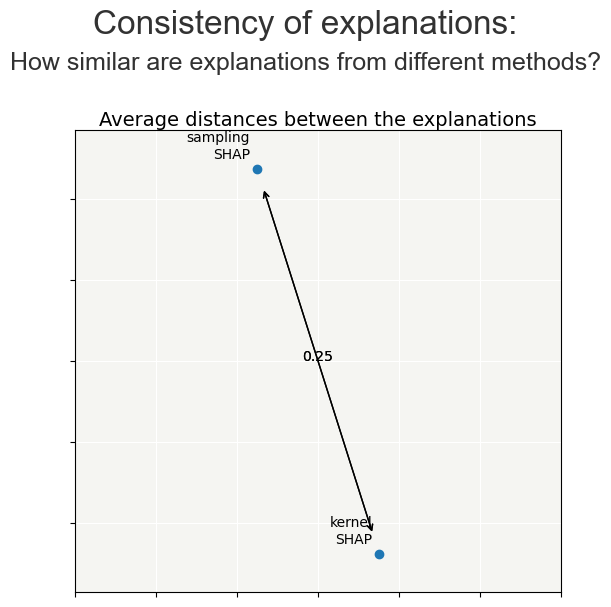

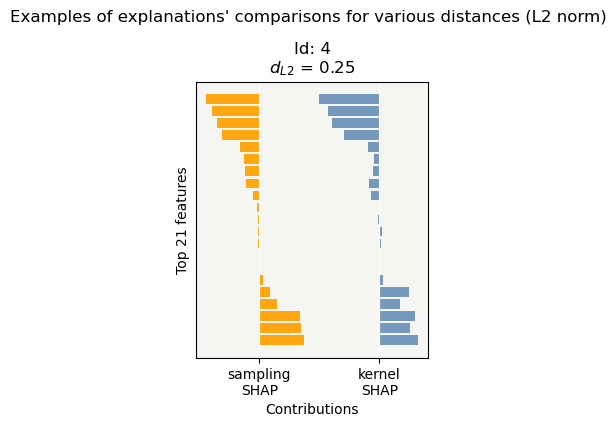

In [101]:
# The format must be a dictionary where keys are methods names and values are pandas DataFrames: be careful to have dataframes with same shape, index and column names
contributions = { "sampling\nSHAP": samplingSHAP, "kernel\nSHAP":kernelSHAP}
# contributions = {"tree\nSHAP": treeSHAP, "sampling\nSHAP": samplingSHAP, "kernel\nSHAP":kernelSHAP}

index = [45, 36, 12, 17, 29]
cns = Consistency()
cns.compile(contributions=contributions,
            x=X_train #Optionnal, needed to display pairwise_consistency_plot
           )
cns.consistency_plot(selection=index, max_features=21)

In [65]:
response_dict = {1: 'Web', 2: 'Not Web'}

features = list(full_dataset.columns)
features_dict = dict(zip(features, features))
xpl = SmartExplainer(
    model=model_poison, 
    #preprocessing=encoder, 
    features_dict=features_dict, # Optional parameters
    label_dict=response_dict    # Optional parameters, dicts specify labels 
)
xpl.compile(x=X_train_w_or_n) # X_train_w_or_n is the sample 
xpl.plot.compacity_plot()

In [122]:
xpl.plot.stability_plot()

In [123]:
index = [1, 2, 3, 8, 9]

# Using distribution = "boxplot" or "violin" displays distributions of variability instead of means
xpl.plot.stability_plot(selection=index, max_features=5, distribution="boxplot")

In [124]:
xpl.plot.local_neighbors_plot(index=1)

In [116]:
from pydoc import classname
import warnings
import shap

classes=['Web', 'Interactive', 'Video']
explainer = shap.KernelExplainer(model_poison.predict, X_train_new)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_train_new, nsamples=100)
#print(shap_values)

  0%|          | 0/279 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 0
INFO:shap:remaining_weight_vector = [0.29184991 0.15360522 0.10809256 0.08583821 0.07296248 0.06485554
 0.05956121 0.05612498 0.05404628 0.05306362]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 1.0000000000000002
INFO:shap:np.sum(w_aug) = 21.000000000000004
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = [-0.00994631 -0.00125312  0.          0.01175007 -0.01176998 -0.00480287
  0.         -0.05878691 -0.00626663  0.         -0.0131537   0.00057214
  0.         -0.03913464 -0.0457458   0.          0.         -0.01322022
  0.         -0.00537464  0.        ]
INFO:shap:num_full_subsets = 0
INFO:shap:remaining_weight_vector = [0.29184991 0.15360522 0.10809256 0.08583821 0.07296248 0.06485554
 0.05956121 0.05612498 0.05404628 0.05306362]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 1.0000000000000002
INFO:shap:np.sum(w_aug) = 21.000000000000007
INFO:shap:np.sum(self.kernelWeights) = 1.00000000000000

In [117]:
# shap_values[0]

array([-0.00994631, -0.00125312,  0.        ,  0.01175007, -0.01176998,
       -0.00480287,  0.        , -0.05878691, -0.00626663,  0.        ,
       -0.0131537 ,  0.00057214,  0.        , -0.03913464, -0.0457458 ,
        0.        ,  0.        , -0.01322022,  0.        , -0.00537464,
        0.        ])

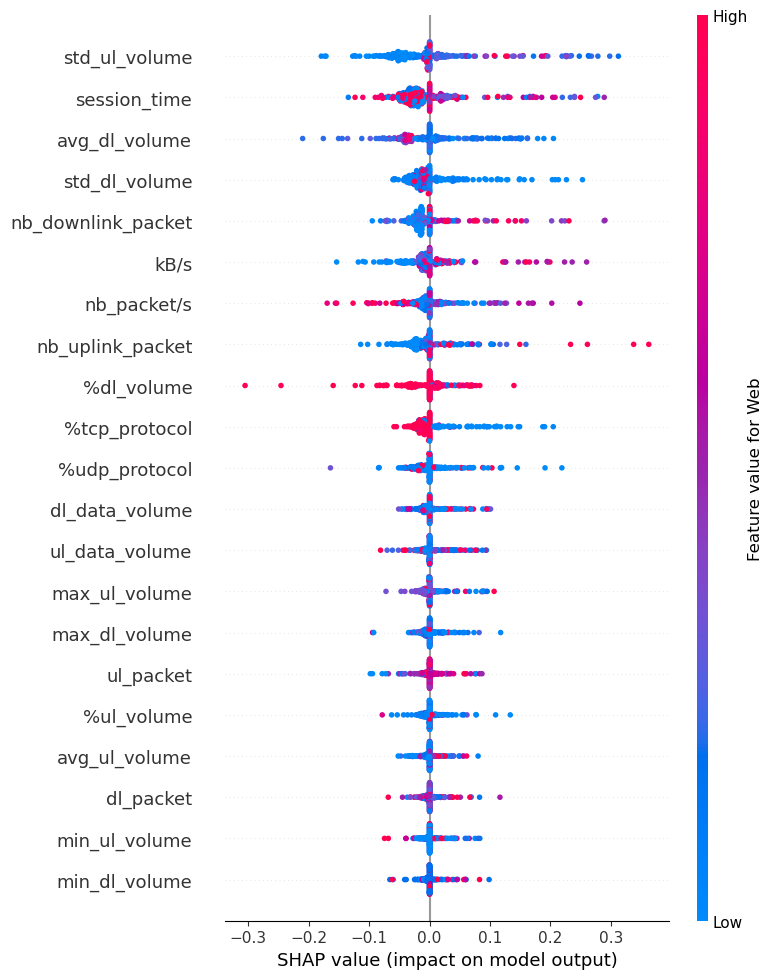

In [121]:
shap.summary_plot(shap_values, X_train_new, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Web', plot_type="violin")
# shap.summary_plot(shap_values[1], X_test, feature_names=features, max_display=24, 
#                     class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
# shap.summary_plot(shap_values[2], X_test, feature_names=features, max_display=24, 
#                     class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

# shap.summary_plot(shap_values, X_test, feature_names=features, max_display=24, 
#                     class_names=classes, color_bar_label='Feature value for all')